In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

# Datasets


### NCI

We build one large graph that really consists of 4000+ smaller ones (there are 2 datasets, NCI1 and NCI109).
For each vertex, we have the following attributes:
* name:  unique for each vertex (1-based str)
* graph: id of the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices are assigned to a small graph, but are not part of any edge.
When extracting the small graphs, we consider the giant connected component only.

Each small graph belongs to one of two classes; the classes are roughly balanced.

### Others


In [2]:
dataset = 'REDDIT-BINARY'
datadir = '../Data/'+dataset+'/'+dataset
has_node_labels = False

## read data from folder
fn_edges = datadir+'.edges'
fn_graph_id = datadir+'.graph_id'
fn_graph_label = datadir+'.graph_labels'
fn_node_label = datadir+'.node_labels'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip())-1 for x in f.readlines()]

## build dictionary (node names are 1-based)
graph_dict = {(x+1):y for x,y in enumerate(sg_mem)}
for v in G.vs:
    v['graph'] = graph_dict[v['name']]

## read and store node labels
if has_node_labels:
    with open(fn_node_label) as f:
        nl = [int(x.strip()) for x in f.readlines()]
    nl_dict = {(x+1):y for x,y in enumerate(nl)}
    for v in G.vs:
        v['label'] = nl_dict[v['name']]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]
print('number of graphs:',len(graph_labels))


number of graphs: 2000


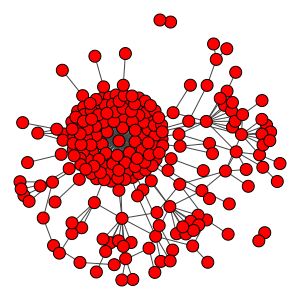

In [4]:
## subgraphs - example
sg_id = 0
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_id)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

### Method 1 - Expander-based Node Features

For every "small" graphs, compute some features derived from expansion properties of vertices.

See details in our blog post.

We can ignore the **node labels** if we want to compare with methods that rely only on the graph structure.


In [5]:
## by default, we ignore vertex labels.
def get_sg_features(sg, ignore_labels=True, depth=7):
    F = []
    n = sg.vcount()
    Deg = sg.degree()
    Lcc = sg.transitivity_local_undirected(mode='zero')
    Bet = np.array(sg.betweenness())/n**2
    Prk = sg.pagerank()
    Cor = sg.coreness()
    if not ignore_labels:
        Lab = sg.vs['label']    
    F.append(Deg)
    F.append(Lcc)
    F.append(Bet)
    F.append(Prk)
    F.append(Cor)
    if not ignore_labels:
        F.append(Lab)
    ## now consider increading depths
    for i in range(depth):
        current = sg.neighborhood_size(order=i+1)
        ## expanding proportion
        F.append([i/n for i in current])
        ## relative expanding properties
        if i>0:
            F.append([i / j for i, j in zip(current, previous)])
        previous = current
        ## aggregate of other features at this depth
        F.append([np.mean([Deg[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Lcc[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Bet[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Prk[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Cor[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        if not ignore_labels:
            F.append([np.mean([Lab[i] for i in x]) for x in sg.neighborhood(order=i+1)])
    F = np.array(F).transpose()
    return F

### Input format

* **node_features**: array (length = number of graphs) of arrays of size "number of vertices x number of features"

Below, we prepare the data we have in this format.

In [6]:
%%time
## feature for every graph - this is the slowest part (~1 min)
node_features = []
rows = []
for i in list(set(G.vs['graph'])):
    ## we keep the giant component for each small graph
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist()).connected_components().giant()
    node_features.append(get_sg_features(sg, ignore_labels=True, depth=7))
    rows.extend(np.repeat(i,sg.vcount()))
node_features = np.array(node_features, dtype=object)


CPU times: user 3h 12min 47s, sys: 1min 20s, total: 3h 14min 7s
Wall time: 52min 35s


### first step - build (graphs x nodes) sparse incidence matrix


In [7]:
## consider all node's feature vectors
node_vectors = np.vstack(node_features)

In [8]:
%%time
## incidence - this is quite fast
n = len(rows)
cols = np.arange(n)
incidence_matrix = scipy.sparse.csr_matrix((np.repeat(1.0,n).astype(np.float32), (rows, cols)))
incidence_matrix

CPU times: user 124 ms, sys: 11.5 ms, total: 135 ms
Wall time: 135 ms


<2000x851133 sparse matrix of type '<class 'numpy.float32'>'
	with 851133 stored elements in Compressed Sparse Row format>

### second step - embed graphs via Wasserstein's

In [9]:
%%time
## embed the graphs via distributions over node vectors - also fast
graphs_embed = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(incidence_matrix, vectors=node_vectors)
graphs_embed.shape

CPU times: user 1.47 s, sys: 4.3 s, total: 5.77 s
Wall time: 1.43 s


(2000, 53)

In [10]:
%%time
## same as above, but with normalized vectors
node_vectors_norm = normalize(node_vectors, axis=1, norm='l1')
graphs_embed_norm = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(incidence_matrix, vectors=node_vectors_norm)
graphs_embed_norm.shape

CPU times: user 1.17 s, sys: 6.46 s, total: 7.63 s
Wall time: 4.8 s


(2000, 53)

## Recursive part - looking at each node's neighbourhood

This is based on Valerie's experiment: https://github.com/vpoulin/graphs-Vectorization

We do a single iteration below.


In [11]:
## some work req'd as we kept only the giant components from overall graph G
## we could speed this up when building G in the first place if required
G_pruned = G.copy()
drop = set()
for i in list(set(G_pruned.vs['graph'])):
    sg = G_pruned.subgraph(np.where(np.array(G_pruned.vs['graph']) == i)[0].tolist()).connected_components().giant()
    ssg = G_pruned.subgraph(np.where(np.array(G_pruned.vs['graph']) == i)[0].tolist())
    if sg.vcount() != ssg.vcount():
        drop = drop.union(set(ssg.vs['name']) - set(sg.vs['name']))
G_pruned.delete_vertices([G_pruned.vs.find(name=x).index for x in drop])
G_pruned.vcount()


851133

In [12]:
%%time
## incidence matrix
node_incidence_matrix = G_pruned.get_adjacency_sparse()
node_incidence_matrix.setdiag(1) ## add self to neighbourhoods


CPU times: user 8.31 s, sys: 303 ms, total: 8.61 s
Wall time: 8.61 s


In [13]:
%%time
## apply recursion
n_components = node_vectors.shape[1]
svd = TruncatedSVD(n_components=n_components)

node_vectors_expand = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(node_incidence_matrix, vectors=node_vectors_norm)

node_vectors_expand = normalize(node_vectors_expand, axis=1, norm='l1')

graphs_embed_expand = vectorizers.ApproximateWassersteinVectorizer(
    random_state=42,
    normalization_power=0.66,
).fit_transform(incidence_matrix, vectors=np.hstack([node_vectors_norm,node_vectors_expand]))
graphs_embed_expand_svd = svd.fit_transform(graphs_embed_expand)


CPU times: user 1min 50s, sys: 2min 5s, total: 3min 56s
Wall time: 27.8 s


In [14]:
##save results
import pickle
fn = 'Results/expander_'+dataset+'.pkl'
with open(fn,'wb') as fp:
    pickle.dump( (graphs_embed,
                  graphs_embed_norm,
                  graphs_embed_expand,
                  graphs_embed_expand_svd), 
                  fp
    )


In [15]:
print(len(set(G.vs['graph'])), G.vcount(), G_pruned.vcount())

2000 859233 851133


In [18]:
max(G.vs['name'])

859254